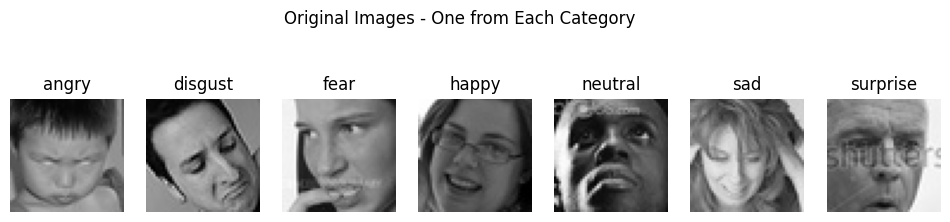

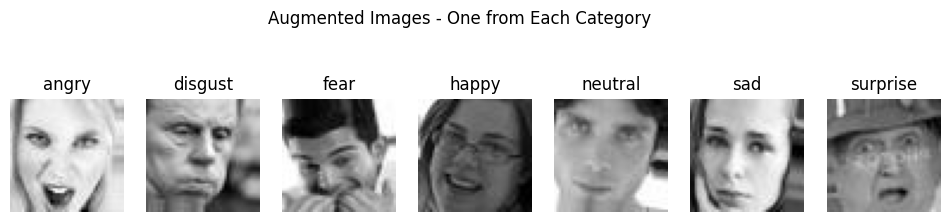

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
958 angry images
111 disgust images
1024 fear images
1774 happy images
1233 neutral images
1247 sad images
831 surprise images


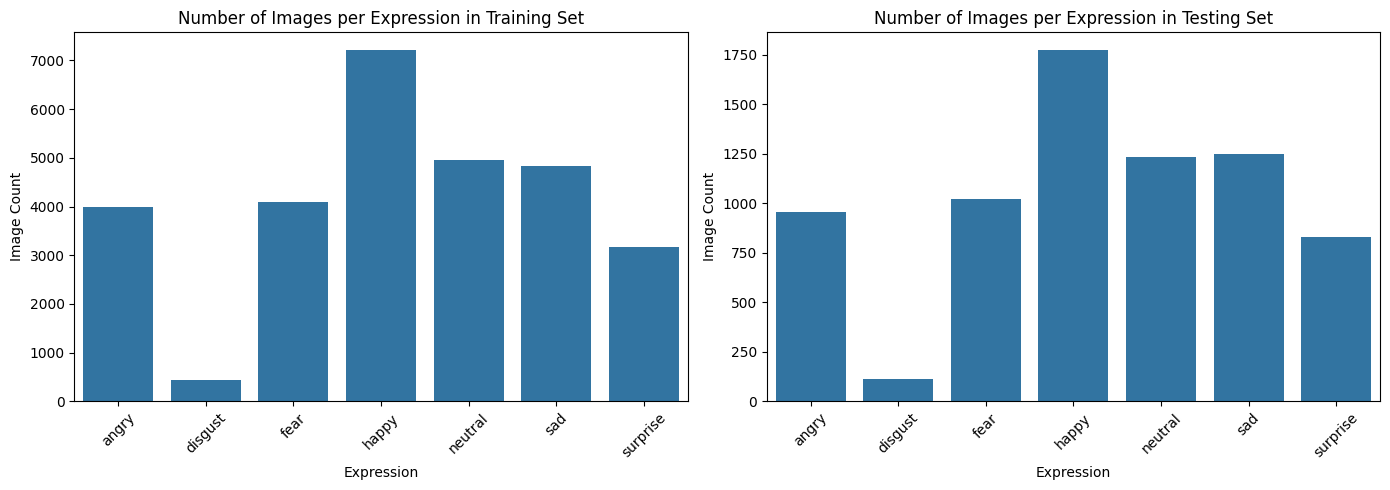

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store the data
expressions_train = []
counts_train = []
expressions_test = []
counts_test = []

# Retrieve and count each expression in the train directory
print(os.listdir("./archive/train/"))
for expression in os.listdir("./archive/train/"):
    count = len(os.listdir("./archive/train/" + expression))
    expressions_train.append(expression)
    counts_train.append(count)
    print(f"{count} {expression} images")

# Retrieve and count each expression in the test directory
print(os.listdir("./archive/test/"))
for expression in os.listdir("./archive/test/"):
    count = len(os.listdir("./archive/test/" + expression))
    expressions_test.append(expression)
    counts_test.append(count)
    print(f"{count} {expression} images")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for training data
sns.barplot(ax=axes[0], x=expressions_train, y=counts_train)
axes[0].set_title('Number of Images per Expression in Training Set')
axes[0].set_xlabel('Expression')
axes[0].set_ylabel('Image Count')
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for testing data
sns.barplot(ax=axes[1], x=expressions_test, y=counts_test)
axes[1].set_title('Number of Images per Expression in Testing Set')
axes[1].set_xlabel('Expression')
axes[1].set_ylabel('Image Count')
axes[1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


In [8]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Initialize lists to store the data
expressions = []
counts_original = []
counts_max = []
counts_median = []

# Load original image counts and prepare for augmentation
for expression in os.listdir("./archive/train/"):
    class_dir = f"./archive/train/{expression}"
    count = len(os.listdir(class_dir))
    expressions.append(expression)
    counts_original.append(count)

# Calculate max and median targets
max_samples = max(counts_original)
median_samples = int(np.median(counts_original))

# Prepare directories for augmented data
os.makedirs("archive_max/train", exist_ok=True)
os.makedirs("archive_median/train", exist_ok=True)

# Perform augmentation for max and median targets
for expression, original_count in zip(expressions, counts_original):
    source_dir = f"./archive/train/{expression}"
    max_dir = f"./archive_max/train/{expression}"
    median_dir = f"./archive_median/train/{expression}"
    os.makedirs(max_dir, exist_ok=True)
    os.makedirs(median_dir, exist_ok=True)
    
    image_paths = [os.path.join(source_dir, f) for f in os.listdir(source_dir)]
    
    # Function to augment data to a target number of samples
    def augment_data(target, destination_dir):
        for image_path in image_paths:
            save_img(os.path.join(destination_dir, os.path.basename(image_path)), load_img(image_path))
        num_augmented_needed = target - original_count
        for i in range(num_augmented_needed):
            image_path = np.random.choice(image_paths)
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            for batch in datagen.flow(image, batch_size=1, save_to_dir=destination_dir, save_prefix='aug', save_format='jpeg'):
                break
    
    # Augment to max
    augment_data(max_samples, max_dir)
    counts_max.append(len(os.listdir(max_dir)))
    
    # Augment to median
    augment_data(median_samples, median_dir)
    counts_median.append(len(os.listdir(median_dir)))


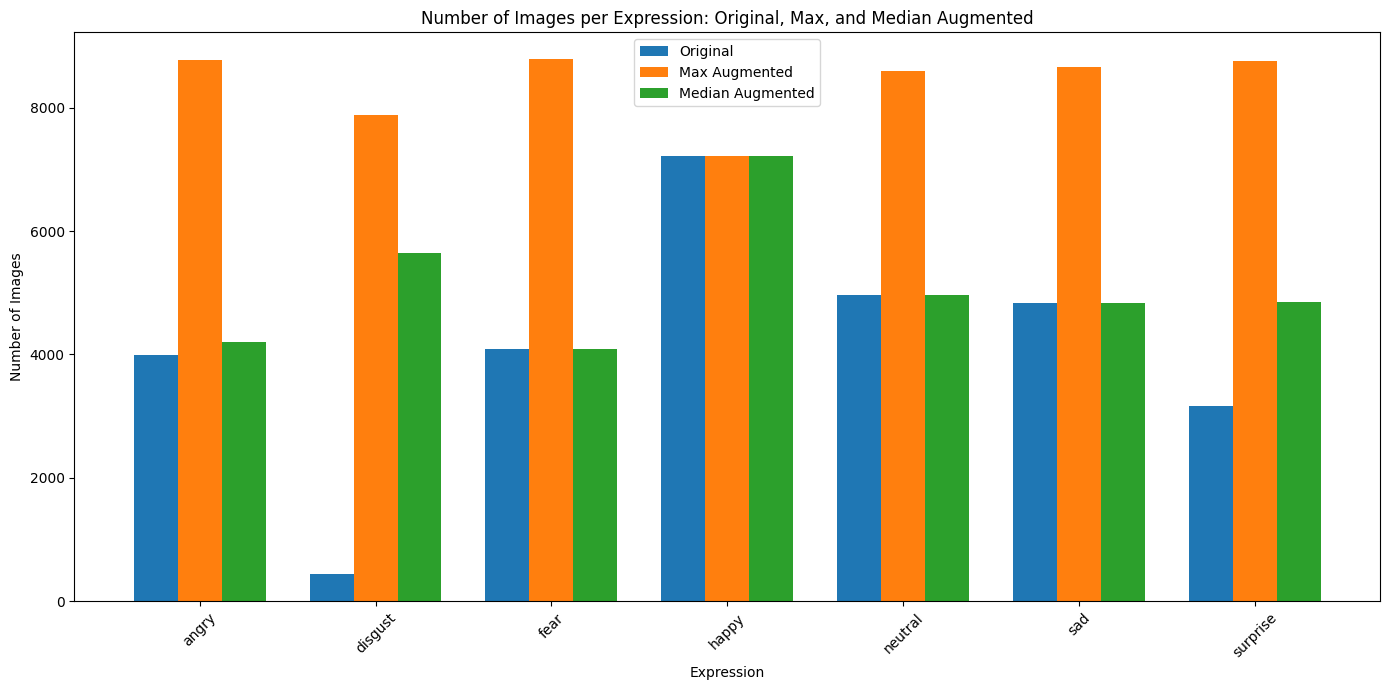

In [9]:

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))
index = np.arange(len(expressions))
bar_width = 0.25

bar1 = ax.bar(index, counts_original, bar_width, label='Original')
bar2 = ax.bar(index + bar_width, counts_max, bar_width, label='Max Augmented')
bar3 = ax.bar(index + 2 * bar_width, counts_median, bar_width, label='Median Augmented')

ax.set_xlabel('Expression')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Expression: Original, Max, and Median Augmented')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(expressions)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Function to display one image from each category
def display_one_image_per_category(base_dir, title):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    categories = os.listdir(base_dir)
    for i, category in enumerate(categories):
        folder_path = os.path.join(base_dir, category)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = load_img(img_path)
            plt.subplot(1, len(categories), i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
            break  # Break after the first image is added
    plt.show()

# Example usage: Displaying one image from each original and augmented category
display_one_image_per_category("./archive/train", "Original Images - One from Each Category")
display_one_image_per_category("./archive_max/train", "Augmented Images - One from Each Category")


In [3]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  model creation functions
def create_conventional_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Define a function to train models
def train_model(model_creator, train_dir, test_dir, epochs=20):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical'
    )
    model = model_creator((48, 48, 1))
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // 32,
        validation_data=test_generator,
        validation_steps=test_generator.samples // 32,
        epochs=epochs
    )
    return model, history

# Paths to the datasets
max_train_dir = './archive_max/train'
median_train_dir = './archive_median/train'
test_dir = './archive/test'

# Train conventional models
max_conv_model, max_conv_history = train_model(create_conventional_model, max_train_dir, test_dir)
median_conv_model, median_conv_history = train_model(create_conventional_model, median_train_dir, test_dir)


# Save the models
max_conv_model.save('max_conv_model1.h5')
median_conv_model.save('median_conv_model1.h5')


Found 46639 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.



Epoch 1/20


1457/1457 [==============================] - 95s 62ms/step - loss: 2.1315 - accuracy: 0.1918 - val_loss: 1.8418 - val_accuracy: 0.2367
Epoch 2/20
1457/1457 [==============================] - 91s 62ms/step - loss: 1.7450 - accuracy: 0.3133 - val_loss: 1.5427 - val_accuracy: 0.3984
Epoch 3/20
1457/1457 [==============================] - 84s 57ms/step - loss: 1.5992 - accuracy: 0.3869 - val_loss: 1.3671 - val_accuracy: 0.4717
Epoch 4/20
1457/1457 [==============================] - 82s 56ms/step - loss: 1.5111 - accuracy: 0.4223 - val_loss: 1.3884 - val_accuracy: 0.4715
Epoch 5/20
1457/1457 [==============================] - 89s 61ms/step - loss: 1.4560 - accuracy: 0.4450 - val_loss: 1.2499 - val_accuracy: 0.5254
Epoch 6/20
1457/1457 [==============================] - 93s 64ms/step - loss: 1.4161 - accuracy: 0.4609 - val_loss: 1.2090 - val_accuracy: 0.5322
Epoch 7/20
1457/1457 [============

c:\Users\safwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


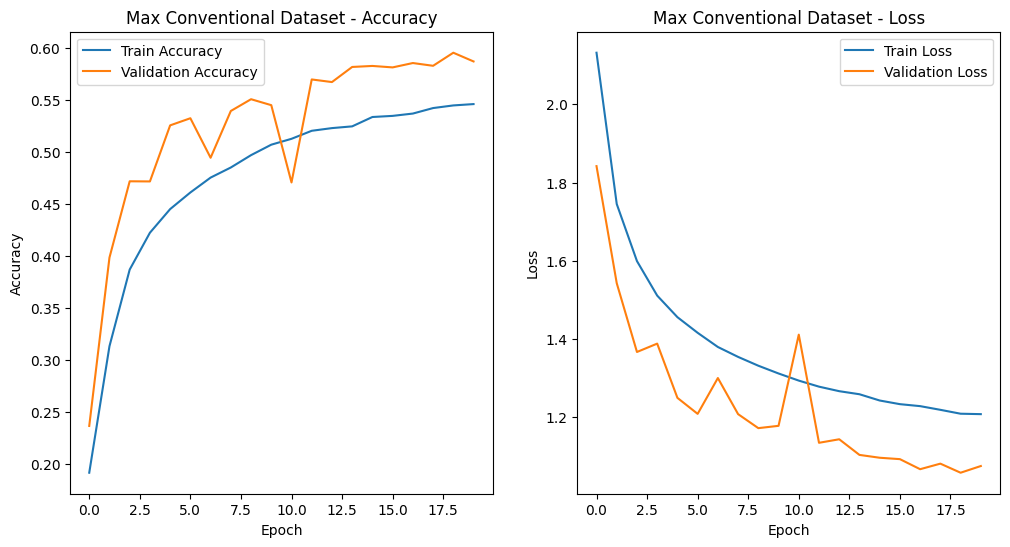

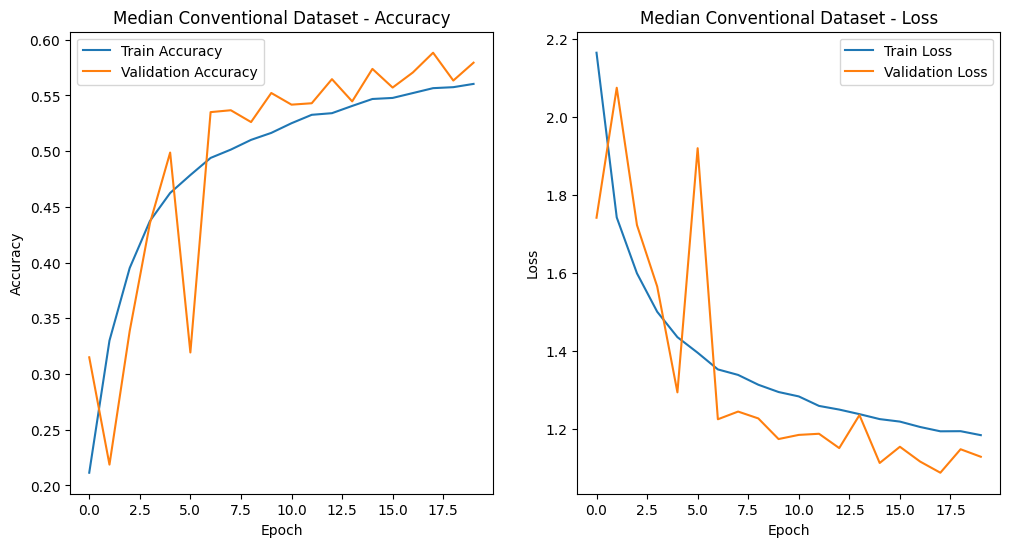

In [4]:
# Function to plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotting the histories for each model
plot_history(max_conv_history, 'Max Conventional Dataset')
plot_history(median_conv_history, 'Median Conventional Dataset')

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 4s 31ms/step
Max Model Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.56      0.52       958
     disgust       0.49      0.42      0.45       111
        fear       0.55      0.15      0.24      1024
       happy       0.80      0.84      0.82      1774
     neutral       0.45      0.74      0.56      1233
         sad       0.49      0.36      0.41      1247
    surprise       0.69      0.77      0.73       831

    accuracy                           0.59      7178
   macro avg       0.57      0.55      0.53      7178
weighted avg       0.59      0.59      0.56      7178

Median Model Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.55      0.50       958
     disgust       0.50      0.01      0.02       111
        fear       0.48      0.17      0.25      1024
       happy       

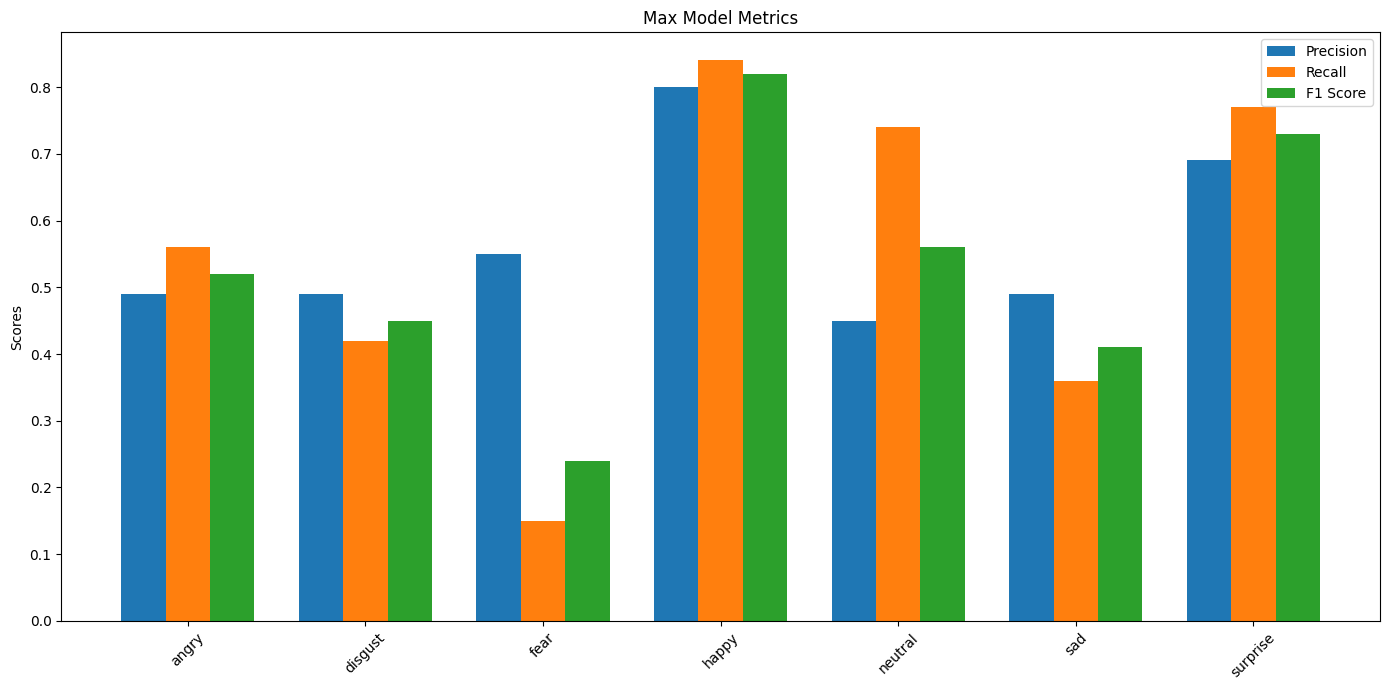

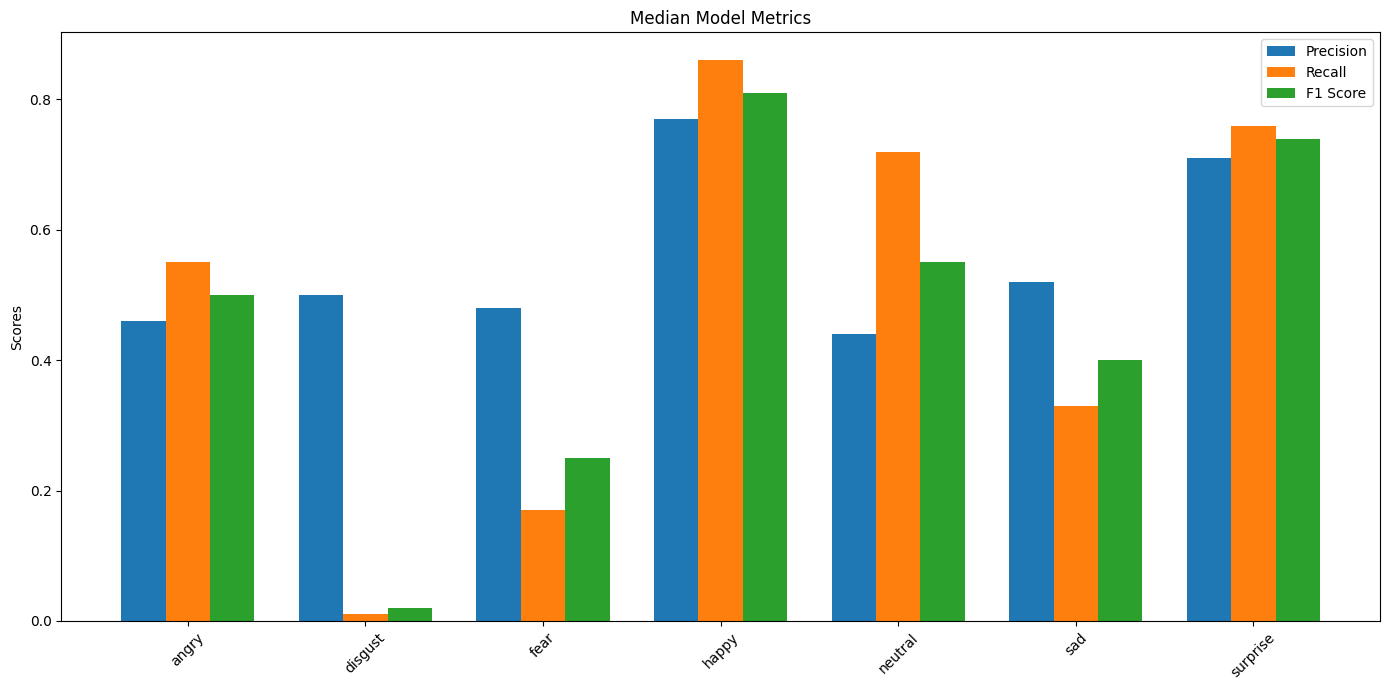

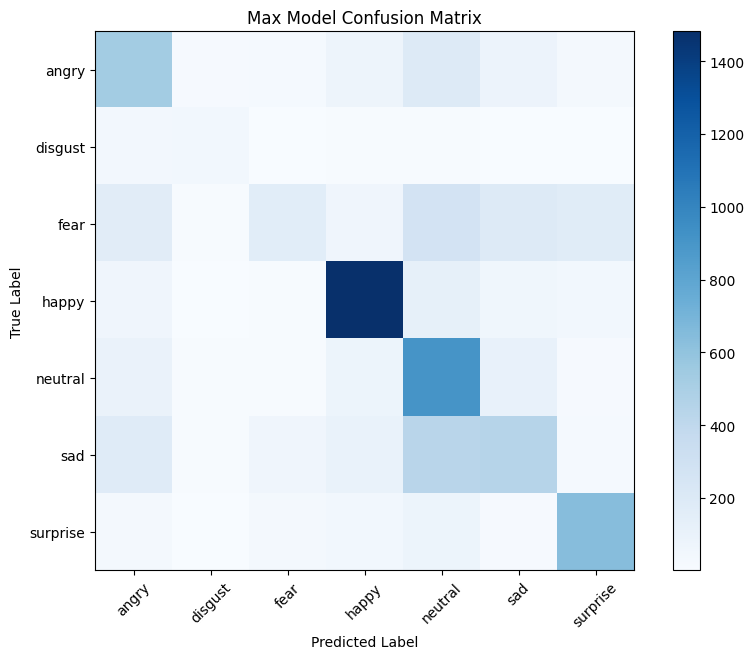

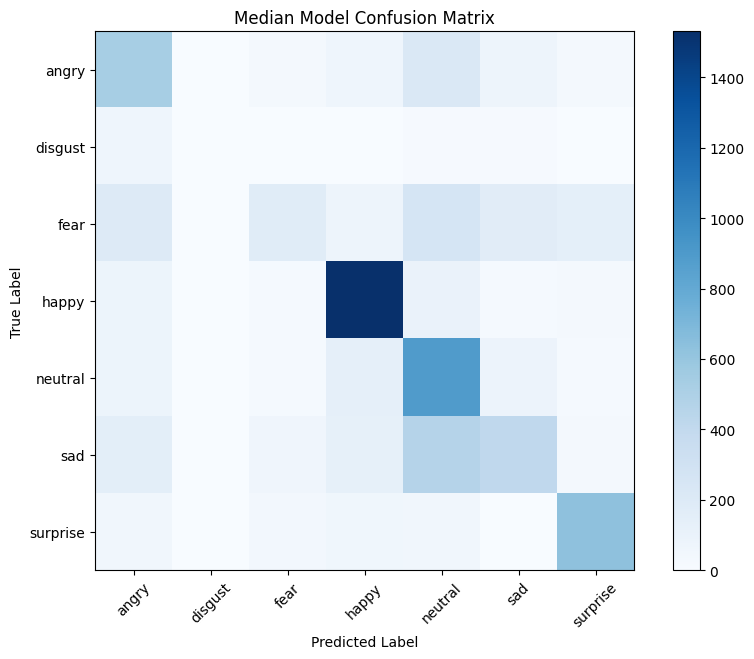

In [6]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Constants
batch_size = 64  # Adjust as necessary to match training settings

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './archive/test/',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # No shuffle for evaluation

# Load the saved models
max_model = load_model('max_conv_model1.h5')
median_model = load_model('median_conv_model1.h5')

# Function to evaluate a model
def evaluate_model(model, generator):
    # Predict the whole generator to keep labels and predictions aligned
    predictions = model.predict(generator, steps=np.ceil(generator.samples / batch_size))

    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class indices
    true_classes = generator.classes

    # Get the class labels for the dataset
    class_labels = list(generator.class_indices.keys())

    # Classification report and confusion matrix
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    cm = confusion_matrix(true_classes, predicted_classes)

    return report, cm, class_labels

# Evaluate both models
max_report, max_cm, class_labels = evaluate_model(max_model, test_generator)
median_report, median_cm, class_labels = evaluate_model(median_model, test_generator)

# Print classification reports
print("Max Model Classification Report:")
print(max_report)
print("Median Model Classification Report:")
print(median_report)

# Function to extract metrics from classification report
def extract_metrics(report):
    lines = report.split('\n')
    precision = {}
    recall = {}
    f1_score = {}
    for line in lines[2:-5]:
        parts = line.split()
        if len(parts) == 5:
            label, p, r, f1, _ = parts
            precision[label] = float(p)
            recall[label] = float(r)
            f1_score[label] = float(f1)
    return precision, recall, f1_score

# Function to plot metrics
def plot_metrics(precision, recall, f1_score, class_labels, title='Model Metrics'):
    p_scores = [precision[label] for label in class_labels]
    r_scores = [recall[label] for label in class_labels]
    f1_scores = [f1_score[label] for label in class_labels]

    x = np.arange(len(class_labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width, p_scores, width, label='Precision')
    rects2 = ax.bar(x, r_scores, width, label='Recall')
    rects3 = ax.bar(x + width, f1_scores, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Extract metrics and plot for both models
max_precision, max_recall, max_f1 = extract_metrics(max_report)
median_precision, median_recall, median_f1 = extract_metrics(median_report)

plot_metrics(max_precision, max_recall, max_f1, class_labels, title='Max Model Metrics')
plot_metrics(median_precision, median_recall, median_f1, class_labels, title='Median Model Metrics')

# Plot confusion matrices
plot_confusion_matrix(max_cm, class_labels, title='Max Model Confusion Matrix')
plot_confusion_matrix(median_cm, class_labels, title='Median Model Confusion Matrix')
